# Mission

- 제공된 타이타닉 데이터셋 사용
- passengerid 대비 생존율을 정확하게 맞출 수 있는 머신러닝 모델 완성

# Connect to google account

In [724]:
from google.colab import drive
import pandas as pd

# 구글 드라이브 마운트
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [725]:
# 코렙 한글깨짐 방지
!apt -qq -y install fonts-nanum > /dev/null

# 데이터 시각화에 사용할 라이브러리
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=fontpath).get_name() 
# fm._rebuild()  

%config InlineBackend.figure_format = 'retina'

plt.rc('font', family=font_name)  
plt.rcParams['axes.unicode_minus'] = False

# Global Variables

In [726]:
import easydict
import json
args = easydict.EasyDict()

# path 정보
args.default_path = '/content/gdrive/My Drive/titanic_kaggle/data/'
args.train_csv = args.default_path+'train.csv'
args.test_csv = args.default_path+'test.csv'
args.submission_csv = args.default_path+'submission.csv'
args.save_results = args.default_path+"model_results.json"

# 데이터 분석을 위한 변수들
args.random_state = 42
SEED = 42
args.results = []

In [727]:
# 데이터 시각화 라이브러리 
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.ion()

import warnings
warnings.filterwarnings('ignore')

In [728]:
# # 지난 결과 확인
# with open(args.save_results, 'r') as file:
#      args.results = json.load(file)

# args.results

# Load Tritanic

- Surived:0=사망, 1=생존
- Pclass: 1=1등석, 2=2등석, 3=3등석
- Sex:male=남성, female=여성
- Age: 나이
- SibSp: 타이타닉 호에 동승한 자매/배우자의 수
- Parch: 타이타닉 호에 동승한 부모/자식의 수
- Ticket: 티켓 번호
- Fare: 승객 요금
- Cabin: 방 호수
- Embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴

In [729]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)

ori_train.shape, ori_test.shape

((916, 12), (393, 11))

In [730]:
ori_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [731]:
ori_train.tail()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
911,911,0,3,"Thomas, Mr. Charles P",male,NaN,1,0,2621,6.4375,NaN,C
912,912,0,3,"Cacic, Mr. Jego Grga",male,18.0,0,0,315091,8.6625,NaN,S
913,913,0,2,"Pengelly, Mr. Frederick William",male,19.0,0,0,28665,10.5000,NaN,S
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q
915,915,1,1,"Candee, Mrs. Edward (Helen Churchill Hungerford)",female,53.0,0,0,PC 17606,27.4458,NaN,C


In [732]:
ori_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  916 non-null    int64  
 1   survived     916 non-null    int64  
 2   pclass       916 non-null    int64  
 3   name         916 non-null    object 
 4   gender       916 non-null    object 
 5   age          736 non-null    float64
 6   sibsp        916 non-null    int64  
 7   parch        916 non-null    int64  
 8   ticket       916 non-null    object 
 9   fare         916 non-null    float64
 10  cabin        198 non-null    object 
 11  embarked     915 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 86.0+ KB


In [733]:
ori_train.describe(include = 'all')

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
count,916.000000,916.000000,916.000000,916,916,736.000000,916.000000,916.000000,916,916.000000,198,915
unique,NaN,NaN,NaN,915,2,NaN,NaN,NaN,703,NaN,146,3
top,NaN,NaN,NaN,"Connolly, Miss. Kate",male,NaN,NaN,NaN,CA. 2343,NaN,G6,S
freq,NaN,NaN,NaN,2,589,NaN,NaN,NaN,7,NaN,4,645
mean,457.500000,0.377729,2.292576,NaN,NaN,29.698370,0.507642,0.361354,NaN,32.402710,NaN,NaN
std,264.570721,0.485084,0.838675,NaN,NaN,14.185627,1.044866,0.828054,NaN,50.506411,NaN,NaN
min,0.000000,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,228.750000,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,457.500000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.458300,NaN,NaN
75%,686.250000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,30.017700,NaN,NaN


## drop_duplicates

In [734]:
print(f'before : {ori_train.shape}')
ori_train.drop_duplicates(keep = 'first', inplace = True, ignore_index = True)
print(f'after : {ori_train.shape}')

before : (916, 12)
after : (916, 12)


# Train_test_split

In [735]:
# 피쳐와 타겟 데이터 분리
X = ori_train.drop('survived', axis = 1)
y = ori_train['survived'] #우리가 알고자하는 생존 데이터

In [736]:
# 카테고리화
new_survived = pd.Categorical(ori_train["survived"])
new_survived = new_survived.rename_categories(["Died","Survived"])              

new_survived.describe()

,counts,freqs
categories,,
Died,570,0.622271
Survived,346,0.377729


In [737]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.3, stratify =y , random_state = SEED)

X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((641, 11), (275, 11), (641,), (275,))

# Column Classification

In [738]:
continous_cols = ['age', 'sibsp', 'parch', 'fare']
category_cols = ['pclass', 'gender', 'embarked']
other_cols = ['passengerid', 'name', 'ticket', 'cabin']

# ModelV10

- ModelV9 결과
  - public score 86점
  - 지속적인 Version Upgrade를 통한 score 상승 필요
  - 오타가 있는지 체크확인 필요
- LGBMClassifier score
  - train : 0.8798751950078003
  - test : 0.8545454545454545
- feature_importances의 상위 5개(변경 전후)
  - 변경 전
    - gender_male :	0.532091
    - age_random : 	0.204676
    - fare	: 0.176452
    - pclass_3.0 : 0.025995
    - sibsp	: 0.024247
  - 피쳐 생성 후
    - gender_female	0.531190
    - fare	0.169875
    - age	0.162931
    - age_	0.031489
    - pclass	0.028754
  - 앙상블 후
    - age	597
    -	fare	436
    -	pclass	122
    -	gender_female	100
    -	sibsp	70
  - 교차검증 KFold 이후
    - age	412
    - fare	345
    - pclass	118
    - gender_female	100
    - parch	91
  - 교차검증 2차 이후
    - age	512
    - fare	269
    - sibsp	106
    - pclass	102
    - gender_female	100
  - V5 HPO 이후
    -	age	493
    - fare	156
    - pclass	146
    - gender_female	100
    - parch	83
  - V6 오타 수정 이후
    - age	177
    - fare	95
    - sibsp	53
    - gender_female	50
    - pclass	45
  - V8 SHAP
    - gender_female
    - gender_pcalss_female_1
    - fare
    - pclass
    - age
    - sibsp
  - v9 인사이트
    - age, age_ , parch, embarked QSC 제거 후 스코어 감소
'

- 인사이트
  - shap를 통한 Feature 중요도 파악 및 선정 재진행
  - 가장 상위권에 있는 gender를 위주로 피쳐를 생성하면 학습에 도움이 될 것이다.
- 가설
  - 유의미한 Feature 찾고 불필요한 것을 제거한다면 Score가 더 오를 것이다.

## Missing value

In [739]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)

X = ori_train.drop('survived', axis = 1)
y = ori_train['survived'] 

from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.3, stratify =y , random_state = SEED)

X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((641, 11), (275, 11), (641,), (275,))

In [740]:
train = X_tr.copy() 
test = X_te.copy()
ori_te = ori_test.copy()

train.shape, test.shape, ori_te.shape

((641, 11), (275, 11), (393, 11))

In [741]:
train.drop('cabin', axis = 1, inplace=True)
test.drop('cabin', axis = 1, inplace=True)
ori_te.drop('cabin', axis = 1, inplace=True)

train.shape, test.shape, ori_te.shape

((641, 10), (275, 10), (393, 10))

In [742]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

def __get_cols_cleaning(p_pd_list:list) -> list:
  cols_cleaning = []
  for df in p_pd_list:
    # 결측치 컬럼 조회
    tmp = df.isnull().sum()
    cols_cleaning += list(tmp[df.isnull().sum() > 0].index)

  cols_cleaning = list(set(cols_cleaning))
  print(f'cols_cleaning: {cols_cleaning}')
  return cols_cleaning

def add_cols_cleaning(p_train:pd.DataFrame, p_test:pd.DataFrame, p_ori_te:pd.DataFrame) -> None:
  pd_list = [p_train, p_test, p_ori_te]
  for col in __get_cols_cleaning(pd_list):  # for col in cols_cleaning:
    for i, df in enumerate(pd_list, start=1): 
      
      if is_numeric_dtype(df[col]): # 숫자형 결측치 처리
        new_col = col+'_cleaning'
        df[new_col] = df[col]   
        # random sampling
        random_sampling = (p_train[col].dropna().sample(df[col].isnull().sum()))
        # index 부여
        random_sampling.index = df[lambda x: x[col].isnull()].index 
        # NA imputation
        df.loc[df[col].isnull(), new_col] = random_sampling
        
        # 기존 결측치 컬럼 제거
        if i == len(pd_list):
          for _df in pd_list:
            _df.drop([col], axis=1, inplace=True)
      
      else: # 범주형 결측치 처리
        df[col].fillna(p_train[col].mode().values[0], inplace=True)

  print(f'p_train: {p_train.isnull().sum().sum()} / p_test: {p_test.isnull().sum().sum()} / p_ori_te: {p_ori_te.isnull().sum().sum()}')

In [743]:
add_cols_cleaning(train, test, ori_te)

cols_cleaning: ['embarked', 'fare', 'age']
p_train: 0 / p_test: 0 / p_ori_te: 0


In [744]:
cols = ['passengerid', 'pclass', 'name', 'gender', 'sibsp', 'parch', 'ticket',
       'embarked', 'fare', 'age']

for df in [train, test, ori_te]:
  df.columns = cols

In [745]:
train.shape, test.shape, ori_te.shape

((641, 10), (275, 10), (393, 10))

In [746]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [747]:
train.corr()

,passengerid,pclass,sibsp,parch,fare,age
passengerid,1.000000,0.041179,-0.011624,-0.054474,-0.048175,-0.036248
pclass,0.041179,1.000000,0.077389,0.071752,-0.555652,-0.375460
sibsp,-0.011624,0.077389,1.000000,0.399212,0.161138,-0.197633
parch,-0.054474,0.071752,0.399212,1.000000,0.189171,-0.181010
fare,-0.048175,-0.555652,0.161138,0.189171,1.000000,0.140458
age,-0.036248,-0.375460,-0.197633,-0.181010,0.140458,1.000000


## Add Feature

In [748]:
train["age_"] = train["age"].map(lambda x: x // 10)
test["age_"] = test["age"].map(lambda x: x // 10)
ori_te["age_"] = ori_te["age"].map(lambda x: x // 10)

train['age_'].unique()

array([6., 3., 2., 1., 4., 0., 5., 7., 8.])

In [749]:
train['gender_age'] = train.apply(lambda row: row['gender']+'_'+str(row['age_']), axis=1)
test['gender_age'] = test.apply(lambda row: row['gender']+'_'+str(row['age_']), axis=1)
ori_te['gender_age'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['age_']), axis=1)

train['gender_age'].unique()

array(['male_6.0', 'female_3.0', 'male_2.0', 'male_1.0', 'male_3.0',
       'male_4.0', 'female_4.0', 'female_6.0', 'female_0.0', 'female_2.0',
       'male_0.0', 'female_1.0', 'male_5.0', 'female_5.0', 'male_7.0',
       'male_8.0', 'female_7.0'], dtype=object)

In [750]:
# train['gender_sibsp'] = train.apply(lambda row: row['gender']+'_'+str(row['sibsp']), axis=1)
# test['gender_sibsp'] = test.apply(lambda row: row['gender']+'_'+str(row['sibsp']), axis=1)
# ori_te['gender_sibsp'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['sibsp']), axis=1)

# train['gender_sibsp'].unique()

In [751]:
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

train['gender_pclass'].unique()

array(['male_1', 'female_1', 'male_3', 'male_2', 'female_3', 'female_2'],
      dtype=object)

In [752]:
train['gender_embarked'] = train.apply(lambda row: row['gender']+'_'+str(row['embarked']), axis=1)
test['gender_embarked'] = test.apply(lambda row: row['gender']+'_'+str(row['embarked']), axis=1)
ori_te['gender_embarked'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['embarked']), axis=1)

train['gender_embarked'].unique()

array(['male_S', 'female_C', 'male_Q', 'female_S', 'male_C', 'female_Q'],
      dtype=object)

In [753]:
for data in [train, test, ori_te]:
  p1 = data['parch'] == 0
  data['parch_solo'] = p1

  p2 = data['parch'] == 1
  data['parch_couple'] = p2

  p3 = data['parch'] == 2 
  p4 = data['parch'] == 3
  p = p3 | p4
  data['parch_family'] = p

  p5 = data['parch'] >= 4
  data['parch_big'] = p5

train.shape, test.shape, ori_te.shape

((641, 18), (275, 18), (393, 18))

## Scaling

In [754]:
from sklearn.preprocessing import StandardScaler

scaling_cols = ['pclass', 'sibsp', 'parch', 'age_', 'fare', 'age']
scaler = StandardScaler()
scaled_dfs = []

for i, df in enumerate([train, test, ori_te]):
  if not i:
    _scaled = scaler.fit_transform(df[scaling_cols])
  else:
    _scaled = scaler.transform(df[scaling_cols])

  _scaled_df = pd.DataFrame(
    _scaled, 
    columns = scaling_cols
  )

  not_scaling_cols = list(set(df.columns) - set(scaling_cols))

  scaled_dfs.append(
    pd.concat(
      [df[not_scaling_cols].reset_index(drop=True), _scaled_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

train = scaled_dfs[0]
test = scaled_dfs[1]
ori_te = scaled_dfs[2]

print(f'{train.isnull().sum().sum()} / {test.isnull().sum().sum()} / {ori_te.isnull().sum().sum()}')
train.shape, test.shape, ori_te.shape

0 / 0 / 0


((641, 18), (275, 18), (393, 18))

In [755]:
train.head()

,ticket,gender_embarked,gender_age,gender_pclass,parch_family,embarked,parch_big,gender,passengerid,parch_couple,name,parch_solo,pclass,sibsp,parch,age_,fare,age
0,113028,male_S,male_6.0,male_1,False,S,False,male,539,False,"Klaber, Mr. Herman",True,-1.519560,-0.496392,-0.437574,2.287204,-0.114641,2.127661
1,PC 17760,female_C,female_3.0,female_1,False,C,False,female,339,False,"Young, Miss. Marie Grice",True,-1.519560,-0.496392,-0.437574,0.292513,2.204701,0.414922
2,SC/A4 23568,male_S,male_2.0,male_3,False,S,False,male,505,False,"Davies, Mr. Evan",True,0.870717,-0.496392,-0.437574,-0.372384,-0.507990,-0.544212
3,315151,male_S,male_2.0,male_3,False,S,False,male,492,False,"Kink, Mr. Vincenz",True,0.870717,1.517451,-0.437574,-0.372384,-0.494967,-0.270173
4,330971,male_Q,male_1.0,male_3,False,Q,False,male,897,False,"Linehan, Mr. Michael",True,0.870717,-0.496392,-0.437574,-1.037281,-0.511622,-0.783995


## Encoding

In [756]:
from sklearn.preprocessing import OneHotEncoder

enc_cols = ['gender', 'embarked', 'gender_pclass', 'gender_embarked','gender_age']
print(f'len_enc_cols: {len(enc_cols)}')
encoder = OneHotEncoder() 
enc_dfs = []

for i, df in enumerate([train, test, ori_te]):
  if not i:
    _encoded = encoder.fit_transform(df[enc_cols])
  else:
    _encoded = encoder.transform(df[enc_cols])

  _encoded_df = pd.DataFrame(
    _encoded.toarray(), 
    columns = encoder.get_feature_names_out()
  )

  not_enc_cols = list(set(df.columns) - set(enc_cols))
  enc_dfs.append(
    pd.concat(
      [df[not_enc_cols].reset_index(drop=True), _encoded_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

train = enc_dfs[0]
test = enc_dfs[1]
ori_te = enc_dfs[2]

print(f'{train.isnull().sum().sum()} / {test.isnull().sum().sum()} / {ori_te.isnull().sum().sum()}')
train.shape, test.shape, ori_te.shape

len_enc_cols: 5
0 / 0 / 0


((641, 47), (275, 47), (393, 47))

## Modeling

In [757]:
train.columns

Index(['ticket', 'pclass', 'parch_family', 'age_', 'parch_big', 'age',
       'passengerid', 'parch', 'parch_couple', 'name', 'fare', 'parch_solo',
       'sibsp', 'gender_female', 'gender_male', 'embarked_C', 'embarked_Q',
       'embarked_S', 'gender_pclass_female_1', 'gender_pclass_female_2',
       'gender_pclass_female_3', 'gender_pclass_male_1',
       'gender_pclass_male_2', 'gender_pclass_male_3',
       'gender_embarked_female_C', 'gender_embarked_female_Q',
       'gender_embarked_female_S', 'gender_embarked_male_C',
       'gender_embarked_male_Q', 'gender_embarked_male_S',
       'gender_age_female_0.0', 'gender_age_female_1.0',
       'gender_age_female_2.0', 'gender_age_female_3.0',
       'gender_age_female_4.0', 'gender_age_female_5.0',
       'gender_age_female_6.0', 'gender_age_female_7.0', 'gender_age_male_0.0',
       'gender_age_male_1.0', 'gender_age_male_2.0', 'gender_age_male_3.0',
       'gender_age_male_4.0', 'gender_age_male_5.0', 'gender_age_male_6.0',
     

In [758]:
# cols = ['pclass', 'parch_family', 'age_', 'parch_big', 'age',
#        'passengerid', 'parch', 'parch_couple', 'fare', 'parch_solo',
#        'sibsp', 'gender_female', 'gender_male', 'embarked_C', 'embarked_Q',
#        'embarked_S', 'gender_pclass_female_1', 'gender_pclass_female_2',
#        'gender_pclass_female_3', 'gender_pclass_male_1',
#        'gender_pclass_male_2', 'gender_pclass_male_3',
#        'gender_embarked_female_C', 'gender_embarked_female_Q',
#        'gender_embarked_female_S', 'gender_embarked_male_C',
#        'gender_embarked_male_Q', 'gender_embarked_male_S',
#        'gender_age_female_0.0', 'gender_age_female_1.0',
#        'gender_age_female_2.0', 'gender_age_female_3.0',
#        'gender_age_female_4.0', 'gender_age_female_5.0',
#        'gender_age_female_6.0', 'gender_age_female_7.0', 'gender_age_male_0.0',
#        'gender_age_male_1.0', 'gender_age_male_2.0', 'gender_age_male_3.0',
#        'gender_age_male_4.0', 'gender_age_male_5.0', 'gender_age_male_6.0',
#        'gender_age_male_7.0', 'gender_age_male_8.0']

# X_tr = train[cols]
# X_te = test[cols]
# ori_te = ori_te[cols]

# X_tr.shape, X_te.shape, ori_te.shape

In [759]:
# cols = ['pclass', 'age_', 'age', 'parch', 'fare',
#        'sibsp', 'gender_female', 'gender_male', 'embarked_C', 'embarked_Q',
#        'embarked_S', 'gender_pclass_female_1', 'gender_pclass_female_2',
#        'gender_pclass_female_3', 'gender_pclass_male_1',
#        'gender_pclass_male_2', 'gender_pclass_male_3',
#        'gender_embarked_female_C', 'gender_embarked_female_Q',
#        'gender_embarked_female_S', 'gender_embarked_male_C',
#        'gender_embarked_male_Q', 'gender_embarked_male_S',
#        'gender_age_female_0.0', 'gender_age_female_1.0',
#        'gender_age_female_2.0', 'gender_age_female_3.0',
#        'gender_age_female_4.0', 'gender_age_female_5.0',
#        'gender_age_female_6.0', 'gender_age_female_7.0', 'gender_age_male_0.0',
#        'gender_age_male_1.0', 'gender_age_male_2.0', 'gender_age_male_3.0',
#        'gender_age_male_4.0', 'gender_age_male_5.0', 'gender_age_male_6.0',
#        'gender_age_male_7.0', 'gender_age_male_8.0']

# X_tr = train[cols]
# X_te = test[cols]
# ori_te = ori_te[cols]

# X_tr.shape, X_te.shape, ori_te.shape

In [760]:
cols = ['pclass', 'age', 'fare', 'gender_female', 'gender_male', 'embarked_C', 'embarked_Q',
       'embarked_S', 'gender_pclass_female_1', 'gender_pclass_female_2',
       'gender_pclass_female_3', 'gender_pclass_male_1',
       'gender_pclass_male_2', 'gender_pclass_male_3',
       'gender_embarked_female_C', 'gender_embarked_female_Q',
       'gender_embarked_female_S', 'gender_embarked_male_C',
       'gender_embarked_male_Q', 'gender_embarked_male_S',
       'gender_age_female_0.0', 'gender_age_female_1.0',
       'gender_age_female_2.0', 'gender_age_female_3.0',
       'gender_age_female_4.0', 'gender_age_female_5.0',
       'gender_age_female_6.0', 'gender_age_female_7.0', 'gender_age_male_0.0',
       'gender_age_male_1.0', 'gender_age_male_2.0', 'gender_age_male_3.0',
       'gender_age_male_4.0', 'gender_age_male_5.0', 'gender_age_male_6.0',
       'gender_age_male_7.0', 'gender_age_male_8.0']

X_tr = train[cols]
X_te = test[cols]
ori_te = ori_te[cols]

X_tr.shape, X_te.shape, ori_te.shape

((641, 37), (275, 37), (393, 37))

In [761]:
X_tr.shape, X_te.shape, y_te.shape, y_tr.shape

((641, 37), (275, 37), (275,), (641,))

In [762]:
X_tr.reset_index(drop=True, inplace=True)
X_te.reset_index(drop=True, inplace=True)
y_te.reset_index(drop=True, inplace=True)
y_tr.reset_index(drop=True, inplace=True)

> HPO

In [763]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [764]:
import optuna
from sklearn.model_selection import cross_val_score
from optuna.samplers import TPESampler
optuna.logging.disable_default_handler()

from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

from lightgbm import LGBMClassifier, plot_importance

In [765]:
class Objective:
    def __init__(self, x_train, y_train, seed):
        self.x_train = x_train
        self.y_train = y_train
        self.seed = seed
        num_folds=5
        self.cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=self.seed)

    def __call__(self, trial):
        hp = {
            "max_depth" : trial.suggest_int("max_depth", 2, 20),
            "min_samples_split" : trial.suggest_int("min_samples_split", 2, 5),
            "criterion" : trial.suggest_categorical("criterion", ["gini", "entropy"]),
            "max_leaf_nodes" : trial.suggest_int("max_leaf_nodes", 5, 10),
            "n_estimators" : trial.suggest_int("n_estimators", 10, 1000, 50),
            "learning_rate" : trial.suggest_float("learning_rate", 0.01, 0.1)
        }
        model = LGBMClassifier(random_state=self.seed, **hp)
        scores = cross_val_score(model, self.x_train, self.y_train, cv=self.cv, scoring="roc_auc")
        return np.mean(scores)

In [766]:
sampler = TPESampler(seed=SEED)

study = optuna.create_study(
    direction = "maximize",
    sampler = sampler
)
objective = Objective(X_tr, y_tr, SEED)
study.optimize(objective, n_trials=100)

print("Best Score:", study.best_value)
print("Best hp", study.best_params)

Best Score: 0.8845080271032464
Best hp {'max_depth': 2, 'min_samples_split': 5, 'criterion': 'entropy', 'max_leaf_nodes': 6, 'n_estimators': 860, 'learning_rate': 0.05344703319133936}


In [767]:
# 모델 정의
modelV10 = LGBMClassifier(random_state=SEED, **study.best_params)

In [768]:
# 교차 검증
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [789]:
from sklearn.metrics import roc_curve, auc

n_iter = 0
auc_te_lst = []

for train_index, valid_index in skf.split(X_tr, y_tr):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = X_tr.loc[train_index], X_tr.loc[valid_index]
    train_y, valid_y = y_tr.loc[train_index], y_tr.loc[valid_index]
    # 학습
    modelV10.fit(train_x, train_y)
    # 예측
    best_threshold = 0.20876870285445615
    pred_prob = modelV10.predict_proba(valid_x)[:, 1]
    pred_class = (pred_prob >= best_threshold).astype(int)
    # 평가
    fpr, tpr, thresholds = roc_curve(valid_y, pred_class)
    auc_te = auc(fpr, tpr)
    auc_te_lst.append(auc_te)
    print(f'{n_iter} 번째 StratifiedKFold AUC: {auc_te:.4f}, 학습데이터 크기: {train_x.shape}, 검증데이터 크기: {valid_x.shape}')

# 최종 평가
print('-'*50)
print(f'교차 검증 AUC: {np.mean(auc_te_lst):.4f} / 모델 평가: {modelV10.score(X_te, y_te)}')

1 번째 StratifiedKFold AUC: 0.8082, 학습데이터 크기: (512, 37), 검증데이터 크기: (129, 37)
2 번째 StratifiedKFold AUC: 0.7854, 학습데이터 크기: (513, 37), 검증데이터 크기: (128, 37)
3 번째 StratifiedKFold AUC: 0.8292, 학습데이터 크기: (513, 37), 검증데이터 크기: (128, 37)
4 번째 StratifiedKFold AUC: 0.8271, 학습데이터 크기: (513, 37), 검증데이터 크기: (128, 37)
5 번째 StratifiedKFold AUC: 0.8551, 학습데이터 크기: (513, 37), 검증데이터 크기: (128, 37)
--------------------------------------------------
교차 검증 AUC: 0.8210 / 모델 평가: 0.8472727272727273


In [790]:
def find_best_threshold(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    best_threshold = thresholds[np.argmax(tpr-fpr)]
    return best_threshold

In [791]:
best_threshold = find_best_threshold(valid_y, pred_prob)

In [792]:
best_threshold

0.20876870285445615

In [793]:
# 모델 확인
df_feature_importances = pd.DataFrame(modelV10.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances

(37, 2)


,index,0
0,fare,1045
1,age,677
2,pclass,102
3,gender_age_female_3.0,88
4,gender_pclass_female_1,84
5,gender_embarked_female_Q,60
6,gender_female,59
7,embarked_S,48
8,gender_pclass_female_2,43
9,gender_age_female_2.0,40


## Evaluation

In [794]:
# 모델 확인
score_tr = modelV10.score(X_tr, y_tr)
score_te = modelV10.score(X_te, y_te)

score_tr, score_te

(0.9079563182527302, 0.8472727272727273)

In [795]:
# 모델 확인
ori_te_pred = modelV10.predict_proba(ori_te)[:,1]
ori_te_pred.shape

(393,)

In [796]:
# 모델 확인
args.results.append(
    {
        'model': 'modelV12',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0303'
    }
)

> SHAP

In [797]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


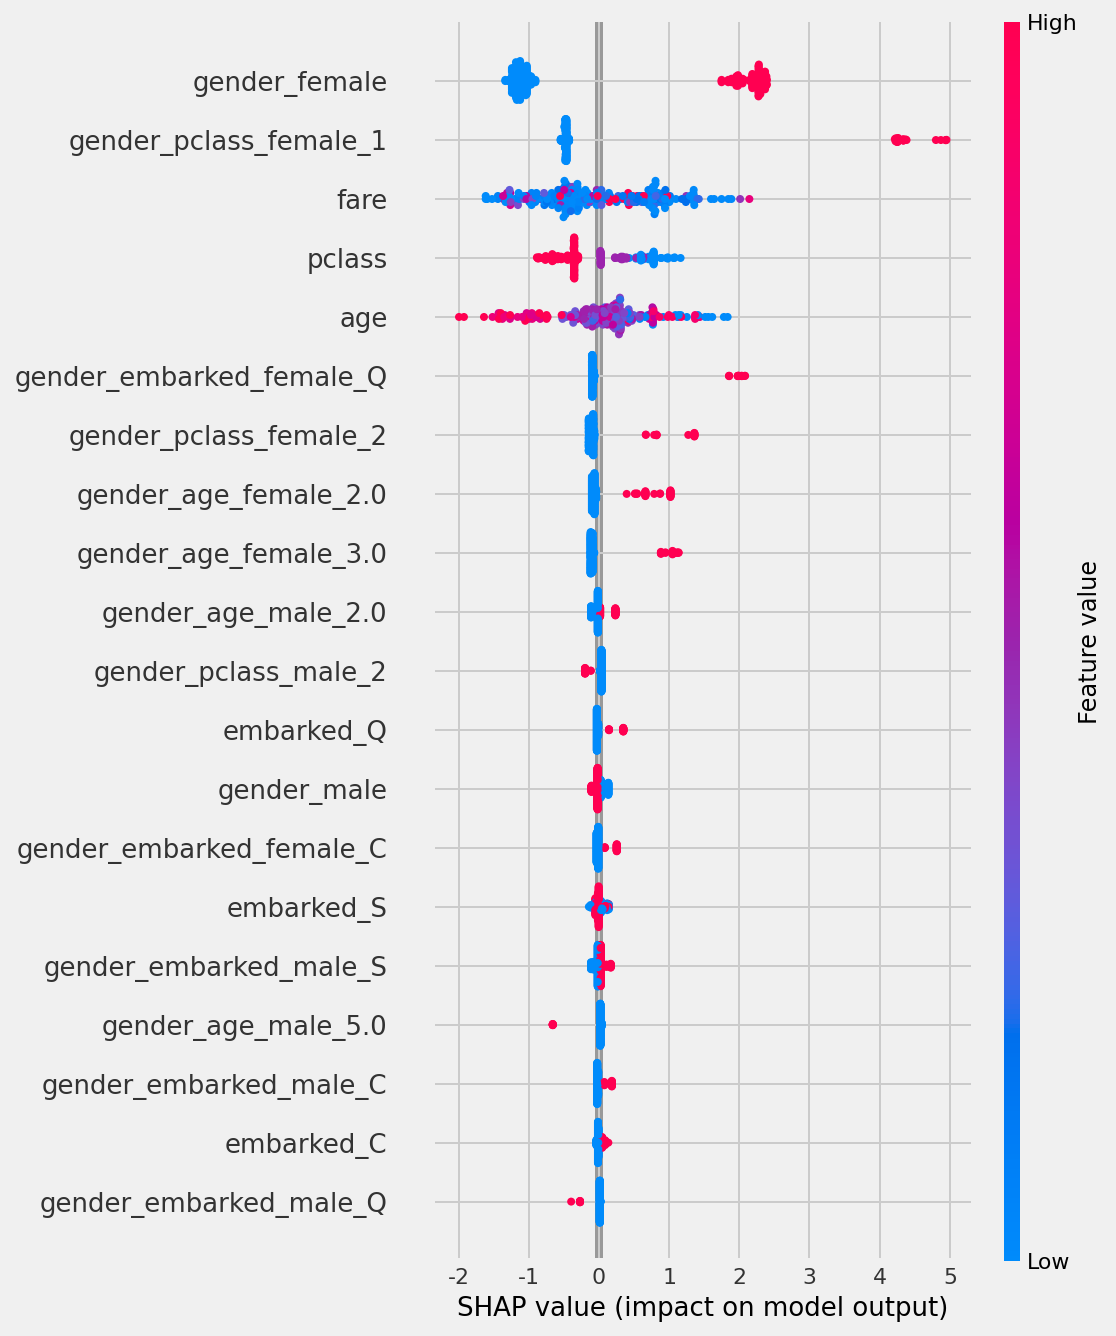

In [798]:
# 모델 확인
import shap
explainer = shap.TreeExplainer(modelV10)
shap_values = explainer.shap_values(X_te)
shap.summary_plot(shap_values[1], X_te)

# Submission

In [799]:
df_results = pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)
df_results

,model,score_tr,score_te,auc_te,ori_te_pred,len_features,feaute_importances,create_dt
1,modelV12,0.907956,0.847273,0.855076,"[0.967733702205378, 0.8884920569370276, 0.9761...",37,"[fare, age, pclass, gender_age_female_3.0, gen...",0303
0,modelV12,0.907956,0.847273,0.809997,"[0.967733702205378, 0.8884920569370276, 0.9761...",37,"[fare, age, pclass, gender_age_female_3.0, gen...",0303


In [800]:
submission = pd.read_csv(args.submission_csv)
submission.head()

,passengerid,survived
0,916,0.967734
1,917,0.888492
2,918,0.976153
3,919,0.029510
4,920,0.993285


In [801]:
submission = pd.read_csv(args.submission_csv)
submission.head()

,passengerid,survived
0,916,0.967734
1,917,0.888492
2,918,0.976153
3,919,0.029510
4,920,0.993285


In [802]:
submission['survived'] = df_results.loc[0, ['ori_te_pred']].values[0]
print(f'{submission.isnull().sum().sum()}')
submission.head(10)

0


,passengerid,survived
0,916,0.967734
1,917,0.888492
2,918,0.976153
3,919,0.029510
4,920,0.993285
5,921,0.990187
6,922,0.105766
7,923,0.088985
8,924,0.243422
9,925,0.017181


In [803]:
submission.to_csv(args.submission_csv, header=True, index=False)

# Save Results

In [804]:
args.save_results

'/content/gdrive/My Drive/titanic_kaggle/data/model_results.json'

In [805]:
df_results.columns

Index(['model', 'score_tr', 'score_te', 'auc_te', 'ori_te_pred',
       'len_features', 'feaute_importances', 'create_dt'],
      dtype='object')

In [806]:
df_results.drop(['ori_te_pred'], axis=1, inplace=True) 

In [807]:
df_results.to_json(args.save_results, orient="records")

In [808]:
df_results.head()

,model,score_tr,score_te,auc_te,len_features,feaute_importances,create_dt
1,modelV12,0.907956,0.847273,0.855076,37,"[fare, age, pclass, gender_age_female_3.0, gen...",0303
0,modelV12,0.907956,0.847273,0.809997,37,"[fare, age, pclass, gender_age_female_3.0, gen...",0303
